# Characterizing time-dependent error channels with Machine learning 
By combining dynamical decoupling, Ramsey measurements and machine learning we aim to seperate and characterize time-dependent error channels. 

__The goal of this code is to demo a protocol for characterizing time-dependent Pauli error channels and distinguishing between them. We start by an example to distinguish between x and z errors on a qubit. For ion traps x corresponds to laser amplitude fluctuations and z to laser frequency drift. We apply dynamical decoupling x,z gates to get the first and second (time-) integrals of the noise signals. 
Here we first demo the protocol up to first order in Dyson series (assuming F and G are small) because it leads to a nice formulae. However, this contains an error which is the sum of 2nd order terms in Dyson series and we will need to rotate the axis of DD gates to compensate for it. In order to do so we utilize ML algorithms (such as RNNs) to rotate the z axis in order to minimize the L1 norm between predicted and actual error signals (more late). This protocol could be adjusted to an experiment depending on whether the change in axis is done online or offline or a combination of them.
Protocol: Consider the Hamiltonian $H = f(t)*\sigma_x + g(t)*\sigma_z$, which includes both $X$ and $Z$ errors. We first apply the sequence $(\sigma_x*U_\tau*\sigma_x*U_\tau)*...(\sigma_x*U_\tau*\sigma_x*U_\tau)*(\sigma_x*U_\tau*\sigma_x*U_\tau)$, where $U_\tau$ is the error Hamiltonian for the duration of $\tau$. This will give $e^{-i(\frac{1}{N\tau} I^{(2)}_f(N\tau) \sigma_x - I^{(1)}_g(N\tau)\sigma_z )}$, where for small values of $\tau$, $I^{(j)}_{f,g}(N\tau)$ is the $j^{th}$ time-integral of $f,g$, e.g., $I^{(1)}_{f}(N\tau) = \int_0^{N\tau} f(t) dt$ and $I^{(2)}_{f}(N\tau) = \int_0^{N\tau} \int_0^{t} f(t') dt'dt$. Likewise, by applying $(\sigma_z*U_\tau*\sigma_z*U_\tau)*...(\sigma_z*U_\tau*\sigma_z*U_\tau)*(\sigma_z*U_\tau*\sigma_z*U_\tau)$  we obtain $e^{-i( -I^{(1)}_f(N\tau) \sigma_x + \frac{1}{N\tau} I^{(2)}_g(N\tau) \sigma_z )}$. These two sequences together give first and second time integrals of $f(t)$ and $g(t)$.
Machine Learning: Note that this result is valid only up to 1st order in Dysion series (first order in the max amplitude of channels). In an experiment, $\sigma_x$, $\sigma_z$ gates applied will themselves be rotated due to error channel (if e.g., they are applied with the same laser field) and furthermore the gates are not instantanous. These two will both lead to a second order (in amplidute) deviation from the theoretical result. And this is where we will use a machine learning algorithm (such as LSTM) to find the time-dependent correction to the axis orientation which compensates for both of the second order effects.__

In [1]:
from qutip import *
import numpy as np
#import numpy.linalg
#from math import *
#from copy import copy
#from keras.models import Sequential
#from tensorflow import keras
import tensorflow as tf
#import gym
#from gym import error, spaces, utils
#from gym.utils import seeding
#from scipy.special import mathieu_a
import matplotlib.pyplot as plt
#from operators import operators as ops
#from gym_simulation import *
import numpy as np
from scipy.optimize import minimize

In [2]:
#Time-evolution operators 
U_rot = lambda r: (-1.j*(r[0]*sigmax()+r[1]*sigmay()+r[2]*sigmaz())).expm()
U   = lambda F, G: (-1.j*(F*sigmax()+G*sigmaz())).expm()
zUz = lambda F, G: sigmaz()* (-1.j*(F*sigmax()+G*sigmaz())).expm() *sigmaz()
xUx = lambda F, G: sigmax()* (-1.j*(F*sigmax()+G*sigmaz())).expm() *sigmax()

In [3]:
#Test
#Note that U(F, -G) and U(-F, G) equals to xUx(F,G) and zUz(F,G), respectively.  
F, G = 1.,.5
print( xUx(F,G)*U(F,-G).dag() , zUz(F,G)*U(-F,G).dag() ) 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


__Examples__

__Example (1): Let's start with a trivial example of error channel given by a constant Hamiltonian $H = f*\sigma_x + g*\sigma_z$. We first apply the sequence $(\sigma_x*U_\tau*\sigma_x*U_\tau)*...(\sigma_x*U_\tau*\sigma_x*U_\tau)*(\sigma_x*U_\tau*\sigma_x*U_\tau)$, where $U_\tau$ is the error Hamiltonian for the duration of $\tau$. This will give $\exp(-iN\tau( \frac{f}{2}\tau \sigma_x - g\sigma_z))$.
We then apply $(\sigma_z*U_\tau*\sigma_z*U_\tau)*...(\sigma_z*U_\tau*\sigma_z*U_\tau)*(\sigma_z*U_\tau*\sigma_z*U_\tau)$ to obtain $\exp(-iN\tau( \frac{g}{2}\tau \sigma_z - f\sigma_x))$.__

In [4]:
#Constant error channel H = f*x + g*z
tau = 0.0001
N = 10000
f, g = 2., 2. 
F, G = f*tau, g*tau 
zuz, xux, u = zUz(F,G), xUx(F,G), U(F,G)

In [5]:
n = 0
xx_state_list, zz_state_list = [], []
init_state = basis(2,0)
xx_curr_state, zz_curr_state = init_state, init_state
xxDD, zzDD = identity(2), identity(2)
while n<N:
        xx_curr_state, zz_curr_state = (xux*u)*xx_curr_state, (zuz*u)*zz_curr_state
        xx_state_list += [xx_curr_state]
        zz_state_list += [zz_curr_state]
        xxDD, zzDD = (xux*u)*xxDD, (zuz*u)*zzDD 
        n += 1

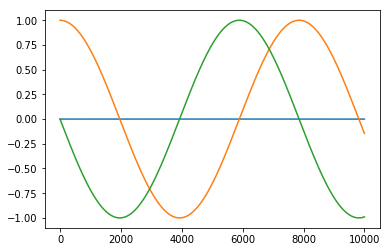

In [6]:
plt.plot([n for n in range(N)], expect(sigmax(), xx_state_list) )
plt.plot([n for n in range(N)], expect(sigmaz(), xx_state_list) )
plt.plot([n for n in range(N)], expect(sigmay(), xx_state_list) )

plt.show()

__We perform Quantum process tomography at the end of the gate sequence in order to find first and second order integrals of the signal:__

In [7]:
def plt_qpt_gate(U_psi, name, figsize=(8,6)):
    # create a superoperator for the density matrix
    # transformation rho = U_psi * rho_0 * U_psi.dag()
    U_rho = spre(U_psi) * spost(U_psi.dag())
    # operator basis for the process tomography
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
    op_label = [["$i$", "$x$", "$y$", "$z$"]]
    # calculate the chi matrix
    chi = qpt(U_rho, op_basis)
    # visualize the chi matrix
    fig, ax = qpt_plot_combined(chi, op_label, name, figsize=figsize)
    ax.set_title(name)
    
    return chi, fig, ax

def get_chi(U_psi):
    # create a superoperator for the density matrix
    # transformation rho = U_psi * rho_0 * U_psi.dag()
    U_rho = spre(U_psi) * spost(U_psi.dag())
    # operator basis for the process tomography
    op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
    # calculate the chi matrix
    chi = qpt(U_rho, op_basis)
    
    return chi

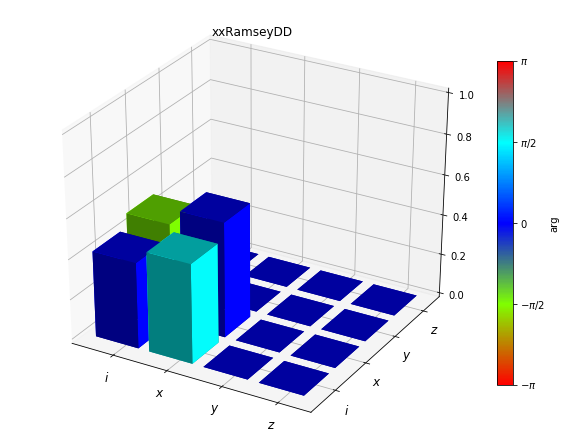

In [8]:
# plot the chi matrix
chi_xxDD = plt_qpt_gate(xxDD, "xxRamseyDD")[0]


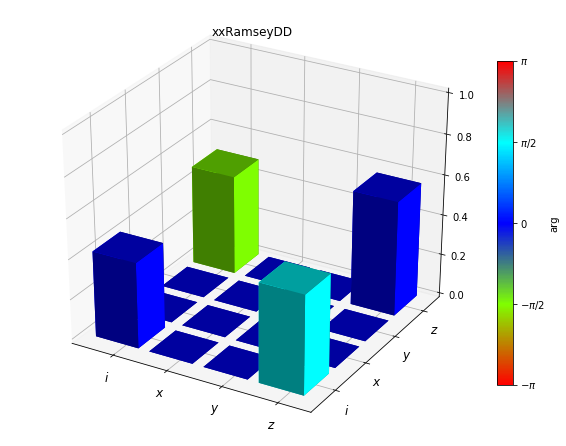

In [9]:
chi_zzDD = plt_qpt_gate(zzDD, "xxRamseyDD")[0]

In [10]:
#In measurements we obtain the process matrix 
chi_xxDD, chi_zzDD
#Now we need to go from process matrices (measurement data) to estimate the coherent error channel parameters. 
#We use gradient descent: 



(array([[ 4.27250009e-01+0.00000000e+00j,  0.00000000e+00-4.94679117e-01j,
          0.00000000e+00+9.89358261e-05j,  0.00000000e+00-0.00000000e+00j],
        [ 0.00000000e+00+4.94679117e-01j,  5.72749968e-01+0.00000000e+00j,
         -1.14549997e-04-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
        [ 0.00000000e+00-9.89358261e-05j, -1.14549997e-04-0.00000000e+00j,
          2.29099999e-08+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j]]),
 array([[ 4.27250009e-01+0.00000000e+00j,  2.30291318e-16-1.35525272e-20j,
          1.27366650e-16-9.89358261e-05j,  1.11133325e-12-4.94679117e-01j],
        [ 2.30298094e-16+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-5.33299885e-20j, -3.38813179e-21-2.66645972e-16j],
        [ 1.27353098e-16+9.89358261e-05j,  0.00000000e+00+5.33299885e-20j,
          2.29099

In [24]:
def chi_err(r,chi_measurement=chi_xxDD):
    U_psi = U_rot(r)
    return np.sum(np.abs(get_chi(U_psi)-chi_measurement)**2)

r0 = np.array([-1., .1, 1.])
res = minimize(chi_err, r0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 160
         Function evaluations: 284


In [25]:
res.x

array([-2.28318529e+00,  4.56633238e-04, -3.21537736e-10])

In [13]:
np.pi/2

1.5707963267948966

In [18]:
1./0.85

1.1764705882352942

In [ ]:
s